# SCNIEC+

This notebook runs the SCENIC+ framework for unpaired scRNA-seq and scATAC-seq on the tumor cells from the Spermatogenesis Mouse dataset 

In [24]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
sys.path.append('/home/sussmanj/miniconda3/envs/scenicplus/lib/')
_stderr = sys.stderr
null = open(os.devnull,'wb')

%matplotlib inline

In [25]:
import importlib
import sys
import os 
import scanpy as sc
from scipy.io import mmread
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from scenicplus.scenicplus_class import SCENICPLUS, create_SCENICPLUS_object
from scenicplus.loom import *
from scenicplus.preprocessing.filtering import *
from pycisTopic.cistopic_class import *
from pycisTopic.lda_models import evaluate_models
from pycisTopic.clust_vis import run_umap
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
import itertools
import anndata
import pickle
import dill
from pycisTopic.clust_vis import *
from pycisTopic.topic_binarization import *
from pycisTopic.diff_features import *
from pycisTopic.lda_models import run_cgs_models_mallet
import scipy.sparse as sp
import scipy.io as spio
import pyranges as pr
import numpy as  np
from pycistarget.utils import region_names_to_coordinates
from pycisTopic.lda_models import run_cgs_models
from scenicplus.wrappers.run_pycistarget import run_pycistarget
import pybiomart as pbm
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
from scenicplus.eregulon_enrichment import score_eRegulons
import seaborn as sns
from scenicplus.plotting.dotplot import heatmap_dotplot
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
from scenicplus.RSS import *
from scenicplus.plotting.correlation_plot import *
from pycisTopic.diff_features import find_highly_variable_features
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
import seaborn as sns
import sklearn
from scenicplus.differentiation_potential import *
import mudata

In [3]:
out_dir = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Output/"
scplus_mdata = mudata.read(out_dir + "/scplusmdata.h5mu")

In [4]:
scplus_mdata.uns["direct_e_regulon_metadata"]

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr7:139104080-139104799,LUC7L2,0.014440,0.241431,0.003486,0.003486,ADNP,False,ADNP_direct_+/+,ADNP_direct_+/+_(160g),ADNP_direct_+/+_(171r),1.130714,1,0.821066,182733
1,chr13:19775139-19775686,PSPC1,0.007971,0.237813,0.001896,0.001896,ADNP,False,ADNP_direct_+/+,ADNP_direct_+/+_(160g),ADNP_direct_+/+_(171r),0.975507,1,0.786571,388633
2,chr9:130940721-130941383,PRRC2B,0.033582,0.530147,0.017804,0.017804,ADNP,False,ADNP_direct_+/+,ADNP_direct_+/+_(160g),ADNP_direct_+/+_(171r),2.598342,1,0.804270,149840
3,chr3:47140881-47141480,SETD2,0.037739,0.401779,0.015163,0.015163,ADNP,False,ADNP_direct_+/+,ADNP_direct_+/+_(160g),ADNP_direct_+/+_(171r),1.697664,1,0.810566,98881
4,chr17:82818606-82819329,FOXK2,0.014878,0.419468,0.006241,0.006241,ADNP,False,ADNP_direct_+/+,ADNP_direct_+/+_(160g),ADNP_direct_+/+_(171r),2.134118,1,0.804374,160091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606269,chr12:26121811-26123012,LMNTD1,0.026467,-0.091816,-0.002430,0.002430,ZNF891,False,ZNF891_direct_-/-,ZNF891_direct_-/-_(15g),ZNF891_direct_-/-_(22r),0.161339,-1,-0.032776,351167
606270,chr10:100912374-100913493,WNT8B,0.023139,-0.069120,-0.001599,0.001599,ZNF891,False,ZNF891_direct_-/-,ZNF891_direct_-/-_(15g),ZNF891_direct_-/-_(22r),0.451599,-1,-0.033402,196828
606271,chr3:169772650-169773798,LRRC31,0.042318,-0.062142,-0.002630,0.002630,ZNF891,False,ZNF891_direct_-/-,ZNF891_direct_-/-_(15g),ZNF891_direct_-/-_(22r),0.324519,-1,-0.033100,325551
606272,chr2:112480663-112482927,IL1A,0.030402,-0.078602,-0.002390,0.002390,ZNF891,False,ZNF891_direct_-/-,ZNF891_direct_-/-_(15g),ZNF891_direct_-/-_(22r),0.184120,-1,-0.035879,493785


In [5]:
scplus_mdata.uns["extended_e_regulon_metadata"]

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr4:165326872-165327988,MSMO1,0.017600,0.128553,0.002263,0.002263,AHRR,True,AHRR_extended_+/+,AHRR_extended_+/+_(16g),AHRR_extended_+/+_(17r),1.126661,1,0.126522,92709
1,chr19:36604467-36606005,ZNF345,0.039838,0.067946,0.002707,0.002707,AHRR,True,AHRR_extended_+/+,AHRR_extended_+/+_(16g),AHRR_extended_+/+_(17r),0.672506,1,0.127736,113060
2,chr21:39969621-39970366,PCP4,0.016889,0.162728,0.002748,0.002748,AHRR,True,AHRR_extended_+/+,AHRR_extended_+/+_(16g),AHRR_extended_+/+_(17r),0.755162,1,0.403418,85047
3,chr3:44861323-44862420,CDCP1,0.014746,0.030047,0.000443,0.000443,AHRR,True,AHRR_extended_+/+,AHRR_extended_+/+_(16g),AHRR_extended_+/+_(17r),1.099669,1,0.101383,121499
4,chr17:17205380-17206937,FLCN,0.004815,0.120618,0.000581,0.000581,AHRR,True,AHRR_extended_+/+,AHRR_extended_+/+_(16g),AHRR_extended_+/+_(17r),1.001734,1,0.049552,184276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249101,chr13:51364193-51364901,RNASEH2B,0.017927,-0.321681,-0.005767,0.005767,ZNF143,True,ZNF143_extended_-/-,ZNF143_extended_-/-_(11g),ZNF143_extended_-/-_(11r),0.076970,-1,-0.163365,204958
249102,chr3:13189463-13190233,FBLN2,0.037984,-0.053296,-0.002024,0.002024,ZNF143,True,ZNF143_extended_-/-,ZNF143_extended_-/-_(11g),ZNF143_extended_-/-_(11r),0.071807,-1,-0.043622,168586
249103,chr16:89289293-89290215,RPL13,0.070370,-0.494175,-0.034775,0.034775,ZNF143,True,ZNF143_extended_-/-,ZNF143_extended_-/-_(11g),ZNF143_extended_-/-_(11r),0.207030,-1,-0.366829,112621
249104,chr16:89615234-89616060,CHMP1A,0.067860,-0.371801,-0.025230,0.025230,ZNF143,True,ZNF143_extended_-/-,ZNF143_extended_-/-_(11g),ZNF143_extended_-/-_(11r),0.108414,-1,-0.057281,102160


In [7]:
scplus_mdata

MuData object with n_obs × n_vars = 13022 × 165471
  uns:	'direct_e_regulon_metadata', 'extended_e_regulon_metadata'
  6 modalities
    scRNA_counts:	13022 x 37220
      obs:	'nCount_ATAC', 'nCount_RNA', 'nFeature_ATAC', 'nFeature_RNA', 'orig.ident', 'predicted.celltype_refmap', 'predicted.celltype_refmap.score', 'predicted.celltypegeneral_refmap', 'predicted.celltypegeneral_refmap.score', 'predicted.m.traj.ptime', 'predicted.m.traj.ptime.score', 'predicted.t.traj.ptime', 'predicted.t.traj.ptime.score', 'predicted.trajectory', 'predicted.trajectory.score'
    scATAC_counts:	13022 x 125493
      obs:	'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'predicted.t.traj.ptime.score', 'predicted.t.traj.ptime', 'predicted.m.traj.ptime.score', 'predicted.m.traj.ptime', 'predicted.celltype_refmap.score', 'predicted.celltype_refmap', 'predicted.celltypegeneral_refmap.score', 'predicted.celltypegeneral_refmap', 'predicted.trajectory.score', 'predicted.trajectory'
      var:	'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
    direct_gene_based_AUC:	13022 x 826
    direct_region_based_AUC:	13022 x 826
    extended_gene_based_AUC:	13022 x 553
    extended_region_based_AUC:	13022 x 553

In [8]:
apply_std_filtering_to_eRegulons(scplus_mdata)

2024-11-14 20:08:19,054 Preprocessing INFO     Only keeping positive region-to-gene links
2024-11-14 20:08:19,095 Preprocessing INFO     Only keep extended inf not direct


In [9]:
scplus_mdata

MuData object with n_obs × n_vars = 13022 × 165471
  uns:	'direct_e_regulon_metadata', 'extended_e_regulon_metadata', 'e_regulon_metadata_filtered'
  6 modalities
    scRNA_counts:	13022 x 37220
      obs:	'nCount_ATAC', 'nCount_RNA', 'nFeature_ATAC', 'nFeature_RNA', 'orig.ident', 'predicted.celltype_refmap', 'predicted.celltype_refmap.score', 'predicted.celltypegeneral_refmap', 'predicted.celltypegeneral_refmap.score', 'predicted.m.traj.ptime', 'predicted.m.traj.ptime.score', 'predicted.t.traj.ptime', 'predicted.t.traj.ptime.score', 'predicted.trajectory', 'predicted.trajectory.score'
    scATAC_counts:	13022 x 125493
      obs:	'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'predicted.t.traj.ptime.score', 'predicted.t.traj.ptime', 'predicted.m.traj.ptime.score', 'predicted.m.traj.ptime', 'predicted.celltype_refmap.score', 'predicted.celltype_refmap', 'predicted.celltypegeneral_refmap.score', 'predicted.celltypegeneral_refmap', 'predicted.trajectory.score', 'predicted.trajectory'
      var:	'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
    direct_gene_based_AUC:	13022 x 826
    direct_region_based_AUC:	13022 x 826
    extended_gene_based_AUC:	13022 x 553
    extended_region_based_AUC:	13022 x 553

In [10]:
scplus_mdata.uns['e_regulon_metadata_filtered']

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr7:139104080-139104799,LUC7L2,0.014440,0.241431,0.003486,0.003486,ADNP,False,ADNP_direct_+/+,ADNP_direct_+/+_(160g),ADNP_direct_+/+_(171r),1.130714,1,0.821066,182733
1,chr13:19775139-19775686,PSPC1,0.007971,0.237813,0.001896,0.001896,ADNP,False,ADNP_direct_+/+,ADNP_direct_+/+_(160g),ADNP_direct_+/+_(171r),0.975507,1,0.786571,388633
2,chr9:130940721-130941383,PRRC2B,0.033582,0.530147,0.017804,0.017804,ADNP,False,ADNP_direct_+/+,ADNP_direct_+/+_(160g),ADNP_direct_+/+_(171r),2.598342,1,0.804270,149840
3,chr3:47140881-47141480,SETD2,0.037739,0.401779,0.015163,0.015163,ADNP,False,ADNP_direct_+/+,ADNP_direct_+/+_(160g),ADNP_direct_+/+_(171r),1.697664,1,0.810566,98881
4,chr17:82818606-82819329,FOXK2,0.014878,0.419468,0.006241,0.006241,ADNP,False,ADNP_direct_+/+,ADNP_direct_+/+_(160g),ADNP_direct_+/+_(171r),2.134118,1,0.804374,160091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216540,chr1:23619254-23620085,RPL11,0.009244,0.082179,0.000760,0.000760,ZBTB7A,True,ZBTB7A_extended_-/+,ZBTB7A_extended_-/+_(91g),ZBTB7A_extended_-/+_(151r),0.234546,-1,-0.072358,113926
216541,chr22:28009134-28009661,PITPNB,0.072153,0.453778,0.032741,0.032741,ZBTB7A,True,ZBTB7A_extended_-/+,ZBTB7A_extended_-/+_(91g),ZBTB7A_extended_-/+_(151r),0.095756,-1,-0.099850,112864
216542,chr4:165301731-165302223,SMIM31,0.044347,0.036332,0.001611,0.001611,ZBTB7A,True,ZBTB7A_extended_-/+,ZBTB7A_extended_-/+_(91g),ZBTB7A_extended_-/+_(151r),0.304226,-1,-0.045890,178043
216543,chr8:66521421-66523350,MCMDC2,0.027782,0.135885,0.003775,0.003775,ZBTB7A,True,ZBTB7A_extended_-/+,ZBTB7A_extended_-/+_(91g),ZBTB7A_extended_-/+_(151r),0.648886,-1,-0.030104,154076


In [11]:
scplus_mdata.uns['e_regulon_metadata_filtered'].to_csv(out_dir+'eRegulon_filtered.tsv', sep='\t', index=False)

In [12]:
eRegulon_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"], 
    scplus_mdata["direct_region_based_AUC"], scplus_mdata["extended_region_based_AUC"]],
    axis = 1,
)
eRegulon_AUC.obs = scplus_mdata.obs.loc[eRegulon_AUC.obs_names]

In [13]:
eRegulon_AUC.write(out_dir+'eGRN_AUC.h5ad')

In [15]:
heatmap_dotplot(
    scplus_mudata = scplus_mdata,
    color_modality = "direct_gene_based_AUC",
    size_modality = "direct_region_based_AUC",
    group_variable = "scATAC_counts:predicted.celltype_refmap",
    eRegulon_metadata_key = "direct_e_regulon_metadata",
    color_feature_key = "Gene_signature_name",
    size_feature_key = "Region_signature_name",
    feature_name_key = "eRegulon_name",
    sort_data_by = "direct_gene_based_AUC",
    orientation = "horizontal",
    figsize = (200, 20)
)

2024-11-14 20:10:05,803 matplotlib.font_manager INFO     Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


# In Silico Perturbation

In [26]:
from scenicplus.simulation import (
    train_gene_expression_models,
    simulate_perturbation,
    plot_perturbation_effect_in_embedding
)
import adjustText
from matplotlib.cm import get_cmap

In [27]:
def plot_scenic_umap(ax):
    texts = []
    unique_trajectories = set(eRegulon_gene_AUC.obs["scRNA_counts:predicted.celltype_refmap"])
    cmap = get_cmap("tab10")  # Replace "tab10" with another colormap name if desired
    color_list = [cmap(i) for i in range(len(unique_trajectories))]
    color_dict = dict(zip(unique_trajectories, color_list))
    
    # Plot UMAP
    ax.scatter(
        eRegulon_gene_AUC.obsm["X_umap"][:, 0],
        eRegulon_gene_AUC.obsm["X_umap"][:, 1],
        color=[color_dict[line] for line in eRegulon_gene_AUC.obs["scRNA_counts:predicted.celltype_refmap"]]
    )
    # Plot labels
    for line in set(eRegulon_gene_AUC.obs["scRNA_counts:predicted.celltype_refmap"]):
        line_bc_idc = np.arange(len(eRegulon_gene_AUC.obs_names))[eRegulon_gene_AUC.obs["scRNA_counts:predicted.celltype_refmap"] == line]
        avg_x, avg_y = eRegulon_gene_AUC.obsm["X_umap"][line_bc_idc, 0:2].mean(0)
        texts.append(
            ax.text(
                avg_x,
                avg_y,
                line,
                fontweight = "bold"
            )
        )
    adjustText.adjust_text(texts)


In [28]:
out_dir = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Output/"
scplus_mdata = mudata.read(out_dir + "/scplusmdata.h5mu")

apply_std_filtering_to_eRegulons(scplus_mdata)

eRegulon_gene_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"]],
    axis = 1,
)
eRegulon_gene_AUC.obs = scplus_mdata.obs

2024-11-22 00:15:41,761 Preprocessing INFO     Only keeping positive region-to-gene links
2024-11-22 00:15:41,805 Preprocessing INFO     Only keep extended inf not direct


In [29]:
gene_tf_direct_extended = pd.concat(
    [
        scplus_mdata.uns["direct_e_regulon_metadata"][["Gene", "TF"]].drop_duplicates(),
        scplus_mdata.uns["extended_e_regulon_metadata"][["Gene", "TF"]].drop_duplicates()
    ]
).drop_duplicates()
gene_to_TF = gene_tf_direct_extended.groupby("Gene")["TF"].apply(lambda tfs: list(tfs)).to_dict()

In [30]:
umap = pd.read_csv('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/BALL_metacells_refUMAP.csv')
umap.set_index('Unnamed: 0', inplace=True)
umap.index = umap.index + '___cisTopic'
umap.index.name = None

missing_indices = set(scplus_mdata.obs.index) - set(umap.index)
if missing_indices:
    print("The following indices are missing in 'umap':")
    print(missing_indices)
else:
    # Reorder umap to match scplus_mdata.obs.index
    umap = umap.loc[scplus_mdata.obs.index]


# set pca and umap
eRegulon_gene_AUC.obsm['X_umap'] = umap.to_numpy()

In [8]:
#regressors = pickle.load(open(out_dir + 'BALL_InSilico_Regressors.pkl', 'rb'))

In [32]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/HOXA9_Perturbation.pkl', 'rb'))
df = perturbation_over_iter[11]
df.index = df.index.str.replace("___cisTopic", "", regex=False)
output_file = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/BALL_HOXA9_perturbation_iter_11_processed.tsv"
df.to_csv(output_file, sep="\t")
print(f"Processed file saved to {output_file}.")

perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/HOXA5_Perturbation.pkl', 'rb'))
df = perturbation_over_iter[11]
df.index = df.index.str.replace("___cisTopic", "", regex=False)
output_file = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/BALL_HOXA5_perturbation_iter_11_processed.tsv"
df.to_csv(output_file, sep="\t")
print(f"Processed file saved to {output_file}.")

perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/HOXA3_Perturbation.pkl', 'rb'))
df = perturbation_over_iter[11]
df.index = df.index.str.replace("___cisTopic", "", regex=False)
output_file = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/BALL_HOXA3_perturbation_iter_11_processed.tsv"
df.to_csv(output_file, sep="\t")
print(f"Processed file saved to {output_file}.")

perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/JUNB_Perturbation.pkl', 'rb'))
df = perturbation_over_iter[11]
df.index = df.index.str.replace("___cisTopic", "", regex=False)
output_file = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/BALL_JUNB_perturbation_iter_11_processed.tsv"
df.to_csv(output_file, sep="\t")
print(f"Processed file saved to {output_file}.")

perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/FOSB_Perturbation.pkl', 'rb'))
df = perturbation_over_iter[11]
df.index = df.index.str.replace("___cisTopic", "", regex=False)
output_file = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/BALL_FOSB_perturbation_iter_11_processed.tsv"
df.to_csv(output_file, sep="\t")
print(f"Processed file saved to {output_file}.")

perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/CEBPA_Perturbation.pkl', 'rb'))
df = perturbation_over_iter[11]
df.index = df.index.str.replace("___cisTopic", "", regex=False)
output_file = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/BALL_CEBPA_perturbation_iter_11_processed.tsv"
df.to_csv(output_file, sep="\t")
print(f"Processed file saved to {output_file}.")


Processed file saved to /mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/BALL_HOXA9_perturbation_iter_11_processed.tsv.
Processed file saved to /mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/BALL_HOXA5_perturbation_iter_11_processed.tsv.
Processed file saved to /mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/BALL_HOXA3_perturbation_iter_11_processed.tsv.
Processed file saved to /mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/BALL_JUNB_perturbation_iter_11_processed.tsv.
Processed file saved to /mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/BALL_FOSB_perturbation_iter_11_processed.tsv.
Processed file saved to /mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/BALL_CEBPA_perturbation_iter_11_processed.tsv.


2024-11-19 22:49:41,520 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-11-19 22:50:08,185 Perturbation INFO     Scoring eRegulons.
2024-11-19 22:50:59,731 Perturbation INFO     Projecting perturbation effect in embedding


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide


2024-11-19 23:12:52,548 Perturbation INFO     Calculating grid of arrows
2024-11-19 23:12:52,620 Perturbation INFO     Plotting


<AxesSubplot: >

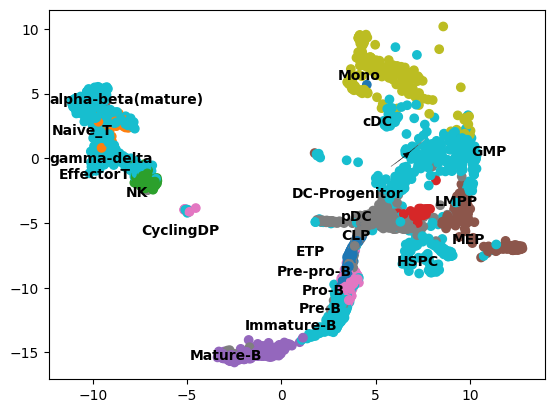

In [9]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/HOXA3_Perturbation.pkl', 'rb'))
fig, ax = plt.subplots()
plot_scenic_umap(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[10],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_umap"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)

2024-11-19 23:13:55,985 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-11-19 23:14:21,968 Perturbation INFO     Scoring eRegulons.
2024-11-19 23:15:13,490 Perturbation INFO     Projecting perturbation effect in embedding


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide


2024-11-19 23:38:38,123 Perturbation INFO     Calculating grid of arrows
2024-11-19 23:38:38,196 Perturbation INFO     Plotting


<AxesSubplot: >

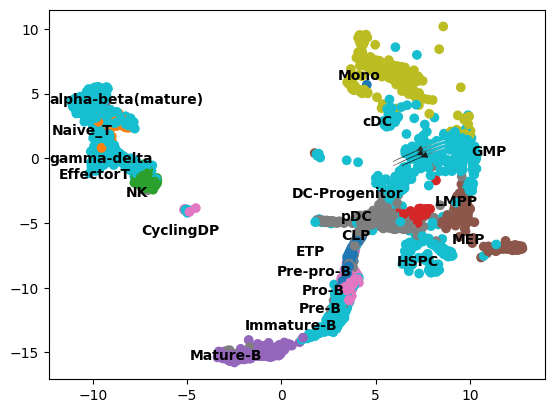

In [10]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/HOXA5_Perturbation.pkl', 'rb'))
fig, ax = plt.subplots()
plot_scenic_umap(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[10],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_umap"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)

2024-11-19 23:39:53,006 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-11-19 23:40:28,024 Perturbation INFO     Scoring eRegulons.
2024-11-19 23:41:25,616 Perturbation INFO     Projecting perturbation effect in embedding


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide


2024-11-20 00:19:12,845 Perturbation INFO     Calculating grid of arrows
2024-11-20 00:19:12,918 Perturbation INFO     Plotting


<AxesSubplot: >

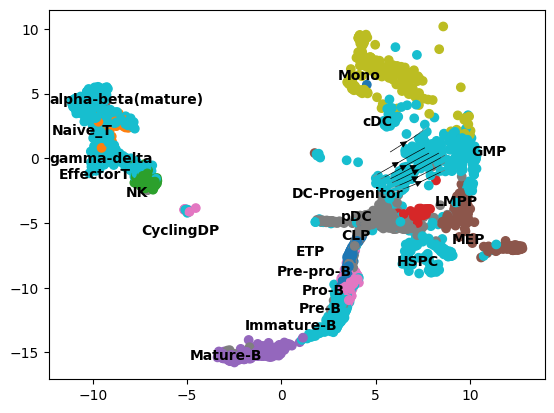

In [11]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/HOXA9_Perturbation.pkl', 'rb'))
fig, ax = plt.subplots()
plot_scenic_umap(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[10],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_umap"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)

2024-11-21 15:20:09,966 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-11-21 15:20:43,432 Perturbation INFO     Scoring eRegulons.
2024-11-21 15:21:44,695 Perturbation INFO     Projecting perturbation effect in embedding


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide


2024-11-21 15:50:33,806 Perturbation INFO     Calculating grid of arrows
2024-11-21 15:50:33,879 Perturbation INFO     Plotting


<AxesSubplot: >

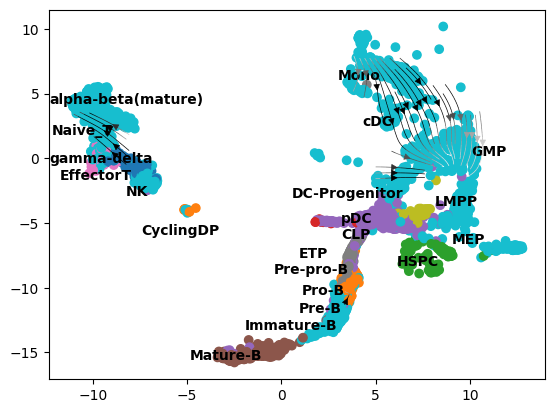

In [8]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/FOSB_Perturbation.pkl', 'rb'))
fig, ax = plt.subplots()
plot_scenic_umap(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[10],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_umap"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)

2024-11-21 15:52:30,488 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-11-21 15:53:04,738 Perturbation INFO     Scoring eRegulons.
2024-11-21 15:54:07,392 Perturbation INFO     Projecting perturbation effect in embedding


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide


2024-11-21 16:24:21,452 Perturbation INFO     Calculating grid of arrows
2024-11-21 16:24:21,529 Perturbation INFO     Plotting


<AxesSubplot: >

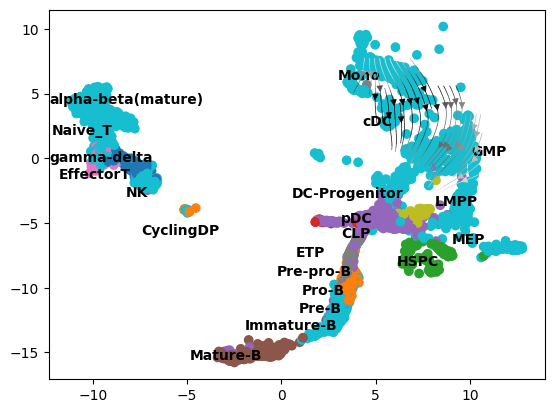

In [9]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/JUNB_Perturbation.pkl', 'rb'))
fig, ax = plt.subplots()
plot_scenic_umap(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[10],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_umap"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)

2024-11-21 16:25:50,418 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-11-21 16:26:19,865 Perturbation INFO     Scoring eRegulons.
2024-11-21 16:27:35,088 Perturbation INFO     Projecting perturbation effect in embedding


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide


2024-11-21 16:57:30,268 Perturbation INFO     Calculating grid of arrows
2024-11-21 16:57:30,342 Perturbation INFO     Plotting


<AxesSubplot: >

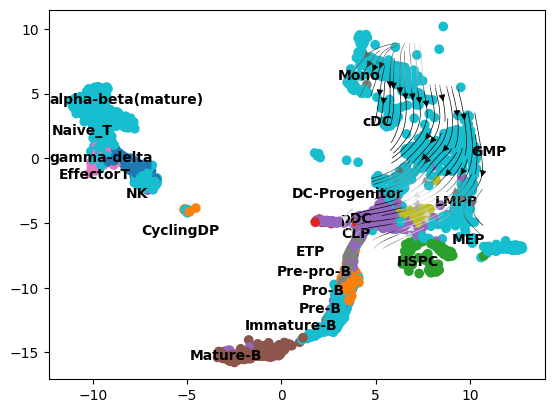

In [10]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/CEBPA_Perturbation.pkl', 'rb'))
fig, ax = plt.subplots()
plot_scenic_umap(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[10],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_umap"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)

Individual Gene Perturbations

In [11]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/B_ALL/Perturbation/HOXA3_Perturbation.pkl', 'rb'))


In [14]:
perturbation_over_iter

{0: Gene                         AL627309.1  AL669831.5  LINC00115    FAM41C  \
 PAYLNH_0_406___cisTopic             0.0    0.228162   0.070669  0.035958   
 PAYLZC_Blast_292___cisTopic         0.0    0.000000   0.000000  0.000000   
 PAYUZJ_0_277___cisTopic             0.0    0.148668   0.000000  0.000000   
 PAYUZM_6_27___cisTopic              0.0    0.000000   0.124135  0.000000   
 PAPIWL_Blast_60___cisTopic          0.0    0.000000   0.000000  0.060085   
 ...                                 ...         ...        ...       ...   
 PAYKGI_1_112___cisTopic             0.0    0.126432   0.000000  0.086038   
 PAYYNY_2_46___cisTopic              0.0    0.252987   0.069495  0.069495   
 PAYWKL_2_214___cisTopic             0.0    0.109633   0.109633  0.056318   
 PAXFFK_Blast_280___cisTopic         0.0    0.000000   0.000000  0.000000   
 PAYYNY_1_77___cisTopic              0.0    0.000000   0.000000  0.000000   
 
 Gene                         AL645608.3     NOC2L    KLHL17  PLEKHN1  

In [ ]:
genes_to_show = ["HOXA10", "SPINK2", "ANXA1", "CD44", "LYL1", "CD34", "SERPINB1", "EGFL7", "IRF1", "FOS"]
cell_type = "Progenitor"
fig, ax = plt.subplots()
baseline = perturbation_over_iter[0].groupby(eRegulon_gene_AUC.obs["scRNA_counts:predicted.trajectory"]).mean().loc[cell_type, genes_to_show]
for gene in genes_to_show:
    ax.plot(
        np.arange(10) + 1,
        [
            np.log2(perturbation_over_iter[i].groupby(eRegulon_gene_AUC.obs["scRNA_counts:predicted.trajectory"]).mean().loc[cell_type, gene] / baseline[gene])
            for i in np.arange(10) + 1
        ],
        label = gene
    )
ax.set_ylabel("Predicted $log{_2}FC$")
ax.set_xlabel("Iteration")
ax.legend()
ax.axhline(y = 0, color = "black")
ax.grid("gray")
ax.set_axisbelow(True)